# Lesson 26: multilayer perceptron activity

## Notebook set up
### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight

## 1. Data preparation

### 1.1. Load diabetes dataset

In [2]:
diabetes_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_train.csv')

In [3]:
diabetes_df.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

Define the label and feature columns below. The label is `diabetes` (binary: 0 or 1). Using separate lists for numerical, nominal and ordinal features makes preprocessing easier.

In [5]:
# Define the label
label = 'diagnosed_diabetes'

# Define numerical features to apply IQR clipping
numerical_features = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total',
    'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes',
    'hypertension_history', 'cardiovascular_history'
]

# Define ordinal features to encode
ordinal_features = ['education_level', 'income_level']

# Define ordinal categories in order
education_categories = [['No formal', 'Highschool', 'Graduate', 'Postgraduate']]
income_categories = [['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']]

# Define features for one-hot encoding
nominal_features = ['gender', 'ethnicity', 'smoking_status', 'employment_status']

# Complete feature list
features = numerical_features + ordinal_features + nominal_features

In [6]:
# Select the features of interest and the label
diabetes_df = diabetes_df[features + [label]]

### 1.2. Train test split

Use `train_test_split` to split the data into training and testing sets. Use `random_state=315` for reproducibility.

In [7]:
training_df, testing_df = train_test_split(diabetes_df, random_state=315, stratify=diabetes_df[label])

### 1.3. Preprocess numerical features

#### 1.3.1. Standard scale

Neural networks perform better when features are scaled. Use `StandardScaler` to fit on the training features and transform both training and testing features.

**Hint:** Fit the scaler on `training_df[features]`, then transform both `training_df[features]` and `testing_df[features]`.

In [8]:
feature_scaler = StandardScaler()
feature_scaler.fit(training_df[numerical_features])

training_df[numerical_features] = feature_scaler.transform(training_df[numerical_features])
testing_df[numerical_features] = feature_scaler.transform(testing_df[numerical_features])

#### 1.3.2. Clip outliers with IQR method

In [9]:
for feature in numerical_features:

    q1 = training_df[feature].quantile(0.25)
    q3 = training_df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    training_df[feature] = training_df[feature].clip(lower_bound, upper_bound)
    testing_df[feature] = testing_df[feature].clip(lower_bound, upper_bound)

### 1.4. Preprocess categorical features

#### 1.4.1. Ordinal feature encoding

In [10]:
ordinal_encoder = OrdinalEncoder(
    categories=education_categories + income_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

ordinal_encoder.fit(training_df[ordinal_features])

training_df[ordinal_features] = ordinal_encoder.transform(training_df[ordinal_features])
testing_df[ordinal_features] = ordinal_encoder.transform(testing_df[ordinal_features])

#### 1.4.2. Nominal feature encoding

In [11]:
# Create one-hot encoder
onehot_encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

onehot_encoder.fit(training_df[nominal_features])

# Convert encoded features to DataFrame
encoded_features_df = pd.DataFrame(
    onehot_encoder.transform(training_df[nominal_features]),
    columns=onehot_encoder.get_feature_names_out(nominal_features),
    index=training_df.index
)

# Remove original nominal features and add encoded versions
training_df = pd.concat([training_df.drop(columns=nominal_features), encoded_features_df], axis=1)
training_df.reset_index(drop=True, inplace=True)

# Repeat for testing data
encoded_features_df = pd.DataFrame(
    onehot_encoder.transform(testing_df[nominal_features]),
    columns=onehot_encoder.get_feature_names_out(nominal_features),
    index=testing_df.index
)

testing_df = pd.concat([testing_df.drop(columns=nominal_features), encoded_features_df], axis=1)
testing_df.reset_index(drop=True, inplace=True)

#### 1.4.3. Update the feature list

In [12]:
features = training_df.columns.tolist()
features.remove(label)

#### 1.4.4. Min/max scale categorical features

In [13]:
categorical_features = [feature for feature in features if feature not in numerical_features]

categorical_scaler = MinMaxScaler(feature_range=(-1, 1))
categorical_scaler.fit(training_df[categorical_features])

training_df[categorical_features] = categorical_scaler.transform(training_df[categorical_features])
testing_df[categorical_features] = categorical_scaler.transform(testing_df[categorical_features])

In [14]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525000 entries, 0 to 524999
Data columns (total 32 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 525000 non-null  float64
 1   alcohol_consumption_per_week        525000 non-null  float64
 2   physical_activity_minutes_per_week  525000 non-null  float64
 3   diet_score                          525000 non-null  float64
 4   sleep_hours_per_day                 525000 non-null  float64
 5   screen_time_hours_per_day           525000 non-null  float64
 6   bmi                                 525000 non-null  float64
 7   waist_to_hip_ratio                  525000 non-null  float64
 8   systolic_bp                         525000 non-null  float64
 9   diastolic_bp                        525000 non-null  float64
 10  heart_rate                          525000 non-null  float64
 11  cholesterol_total         

## 2. Logistic regression model

Logistic regression is a linear model for classification. It serves as a good baseline before trying more complex models like neural networks.

### 2.1. Fit

Create a `LogisticRegression` model and fit it on the training data. Use `max_iter=1000` to ensure convergence.

In [15]:
logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=315)
fit_result = logistic_model.fit(training_df[features], training_df[label])

### 2.2. Test set evaluation

For classification, we can use accuracy, F1 score and/or AUC-ROC (and others) instead of R². Use sklearn's [`metrics`](https://scikit-learn.org/stable/api/sklearn.metrics.html) module .

In [16]:
logistic_predictions = logistic_model.predict(testing_df[features])
logistic_accuracy = logistic_model.score(testing_df[features], testing_df[label])
logistic_f1 = f1_score(testing_df[label], logistic_predictions)
logistic_auc = roc_auc_score(testing_df[label], logistic_model.predict_proba(testing_df[features])[:, 1])

print(f'Logistic regression accuracy on test set: {logistic_accuracy:.4f}')
print(f'Logistic regression F1 score on test set: {logistic_f1:.4f}')
print(f'Logistic regression AUC-ROC score on test set: {logistic_auc:.4f}')

Logistic regression accuracy on test set: 0.6127
Logistic regression F1 score on test set: 0.6671
Logistic regression AUC-ROC score on test set: 0.6531


### 2.3. Performance analysis

For classification, visualize performance using a confusion matrix.

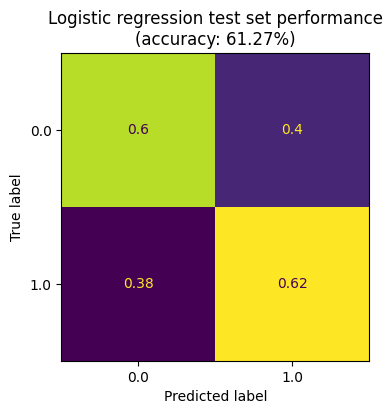

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.set_title(f'Logistic regression test set performance\n(accuracy: {logistic_accuracy:.2%})')

disp_constant = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    logistic_predictions,
    normalize='true',
    ax=ax,
    colorbar=False
)

## 3. Multilayer perceptron (MLP) classifier

Now let's build a neural network classifier using sklearn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

### 3.1. Single epoch training function

Complete the training function below. It should:
1. Split the data into training and validation sets
2. Call `partial_fit` on the model (remember to pass `classes=[0, 1]` on the first call)
3. Record training and validation [`log_loss`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (aka binary cross-entropy) in the history dictionary

**Hint:** Use `model.partial_fit(X, y, classes=[0, 1])` for the first epoch. For subsequent epochs, `partial_fit` remembers the classes.

In [18]:
from sklearn.utils import compute_sample_weight


def train(model: MLPClassifier, df: pd.DataFrame, training_history: dict, classes: list = None) -> tuple[MLPClassifier, dict]:
    '''Trains sklearn MLP classifier model on given dataframe using validation split.
    Returns the updated model and training history dictionary containing training and
    validation log loss. If classes are not provided, assumes 0 and 1.'''

    global features, label

    df, val_df = train_test_split(df, random_state=315)

    # Calculate sample weights
    sample_weights = compute_sample_weight(class_weight='balanced', y=df[label])

    model.partial_fit(
        df[features], df[label],
        classes=classes if classes is not None else [0, 1],
        sample_weight=sample_weights
    )

    training_history['training_loss'].append(log_loss(df[label], model.predict_proba(df[features])))
    training_history['validation_loss'].append(log_loss(val_df[label], model.predict_proba(val_df[features])))

    return model, training_history

### 3.2. Model training

Create an `MLPClassifier` with:
- `hidden_layer_sizes=(64, 32)` - two hidden layers
- `activation='relu'` - ReLU activation function
- `learning_rate_init=0.001` - initial learning rate
- `warm_start=True` - keep weights between calls to fit
- `random_state=315` - for reproducibility

Train for 10 epochs using the training function above.

In [19]:
epochs = 50
print_interval = 5

training_history = {
    'training_loss': [],
    'validation_loss': []
}

mlp_model = MLPClassifier(
    hidden_layer_sizes=(32, 16, 8),
    learning_rate_init=0.00005,
    alpha=0.000005,
    warm_start=True,
    random_state=315
)

for epoch in range(epochs):
    mlp_model, training_history = train(mlp_model, training_df, training_history, classes=[0, 1])

    if (epoch + 1) % print_interval == 0 or epoch == 0 or epoch == epochs - 1:

        print(
            f'Epoch {epoch+1}/{epochs} - ' +
            f'training loss: {training_history["training_loss"][-1]:.4f} - ' +
            f'validation loss: {training_history["validation_loss"][-1]:.4f}'
        )

Epoch 1/50 - training loss: 0.6678 - validation loss: 0.6671
Epoch 5/50 - training loss: 0.6578 - validation loss: 0.6573
Epoch 10/50 - training loss: 0.6561 - validation loss: 0.6559
Epoch 15/50 - training loss: 0.6555 - validation loss: 0.6554
Epoch 20/50 - training loss: 0.6552 - validation loss: 0.6553
Epoch 25/50 - training loss: 0.6550 - validation loss: 0.6552
Epoch 30/50 - training loss: 0.6549 - validation loss: 0.6551
Epoch 35/50 - training loss: 0.6547 - validation loss: 0.6551
Epoch 40/50 - training loss: 0.6546 - validation loss: 0.6551
Epoch 45/50 - training loss: 0.6545 - validation loss: 0.6551
Epoch 50/50 - training loss: 0.6545 - validation loss: 0.6551


### 3.3. Learning curves

Plot the training and validation loss over epochs to visualize the learning process.

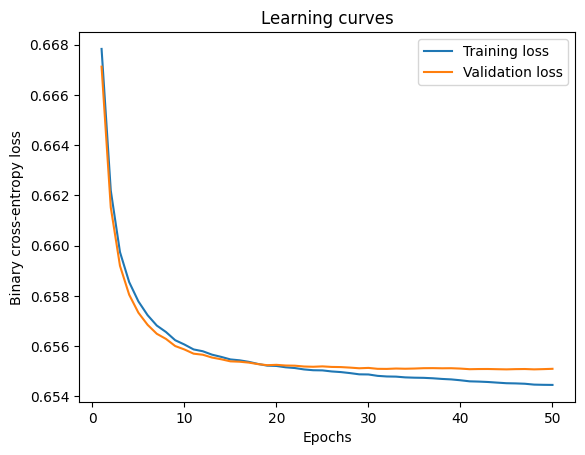

In [20]:
plt.plot(
    range(1, epochs + 1), training_history['training_loss'],
    label='Training loss'
)
plt.plot(
    range(1, epochs + 1), training_history['validation_loss'],
    label='Validation loss'
)
plt.title('Learning curves')
plt.xlabel('Epochs')
plt.ylabel('Binary cross-entropy loss')
plt.legend()
plt.show()

### 3.4. Test set evaluation

Evaluate the MLP model on the test set, similar to how you evaluated the logistic regression model.

In [21]:
mlp_predictions = mlp_model.predict(testing_df[features])
mlp_accuracy = mlp_model.score(testing_df[features], testing_df[label])
mlp_f1 = f1_score(testing_df[label], mlp_predictions)
mlp_auc = roc_auc_score(testing_df[label], mlp_model.predict_proba(testing_df[features])[:, 1])
print(f'MLP accuracy on test set: {mlp_accuracy:.4f}')
print(f'MLP F1 score on test set: {mlp_f1:.4f}')
print(f'MLP AUC-ROC score on test set: {mlp_auc:.4f}')

MLP accuracy on test set: 0.6097
MLP F1 score on test set: 0.6626
MLP AUC-ROC score on test set: 0.6522


### 3.5. Performance analysis

Create a confusion matrix for the MLP model predictions.

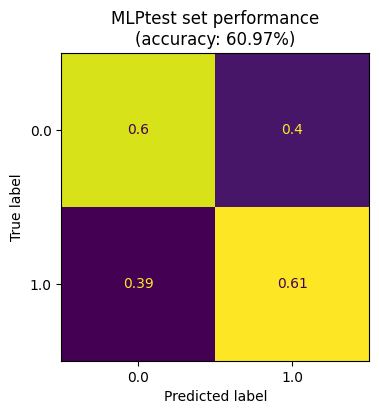

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.set_title(f'MLPtest set performance\n(accuracy: {mlp_accuracy:.2%})')

disp_constant = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    mlp_predictions,
    normalize='true',
    ax=ax,
    colorbar=False
)

## 4. Model comparison

Compare the performance of both models side by side.

In [23]:
print(f'Logistic Regression accuracy on test set: {logistic_accuracy:.4f}')
print(f'MLP accuracy on test set: {mlp_accuracy:.4f}')

Logistic Regression accuracy on test set: 0.6127
MLP accuracy on test set: 0.6097


Create a side-by-side comparison of the confusion matrices for both models.

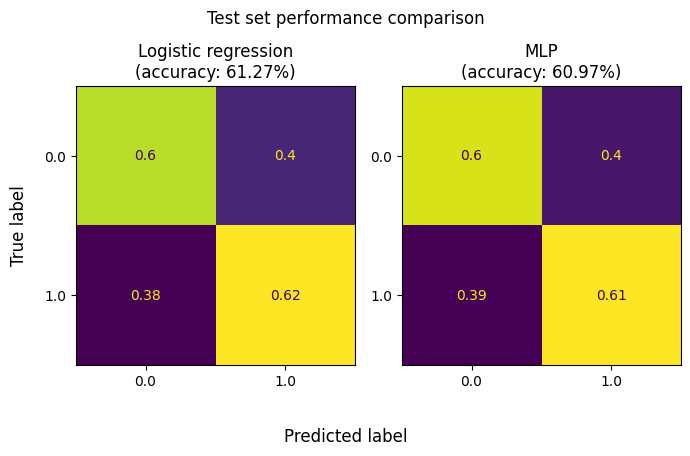

In [24]:
# Compare confusion matrices for baseline and trained model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4.5))

fig.suptitle('Test set performance comparison')
fig.supxlabel('Predicted label')
fig.supylabel('True label')

# Confusion matrix for constant 0 baseline
axes[0].set_title(f'Logistic regression\n(accuracy: {logistic_accuracy:.2%})')

disp_constant = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    logistic_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Confusion matrix for trained model
axes[1].set_title(f'MLP\n(accuracy: {mlp_accuracy:.2%})')

disp_model = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    mlp_predictions,
    normalize='true',
    ax=axes[1],
    colorbar=False
)

axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()